<a href="https://colab.research.google.com/github/flohmannjr/tensorflow_curso/blob/main/TensorFlow_MP3_BitPredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Milestone Project: BitPredict

# Importações

In [1]:
import tensorflow as tf

# import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Configurações e constantes

In [48]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

plt.style.use('seaborn-darkgrid')

COR_TREINO   = '#345cd3'
COR_PREVISAO = '#2dbc2d'
COR_TESTE    = '#f22424'

# Dados

In [3]:
colunas = ['Data', 'Abertura', 'Máximo', 'Mínimo', 'Fechamento']

df = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/dados/BTC_USD_20140917_20230131.csv',
                 header=0,
                 names=colunas,
                 usecols=colunas,
                 parse_dates=['Data'],
                 index_col=['Data'])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3059 entries, 2014-09-17 to 2023-01-31
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Abertura    3059 non-null   float64
 1   Máximo      3059 non-null   float64
 2   Mínimo      3059 non-null   float64
 3   Fechamento  3059 non-null   float64
dtypes: float64(4)
memory usage: 119.5 KB


In [5]:
df

,Abertura,Máximo,Mínimo,Fechamento
Data,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015
2014-09-18,456.859985,456.859985,413.104004,424.440002
2014-09-19,424.102997,427.834991,384.532013,394.795990
2014-09-20,394.673004,423.295990,389.882996,408.903992
2014-09-21,408.084991,412.425995,393.181000,398.821014
...,...,...,...,...
2023-01-27,23030.716797,23417.720703,22654.593750,23078.728516
2023-01-28,23079.964844,23165.896484,22908.845703,23031.089844
2023-01-29,23031.449219,23919.890625,22985.070313,23774.566406


In [6]:
df.describe()

,Abertura,Máximo,Mínimo,Fechamento
count,3059.000000,3059.000000,3059.000000,3059.000000
mean,12931.188036,13256.306288,12570.103885,12937.054107
std,16126.299406,16538.601114,15650.315751,16122.253398
min,176.897003,211.731003,171.509995,178.102997
25%,688.562011,704.736023,674.479981,689.175506
50%,7194.892090,7356.223633,7029.289063,7202.844238
75%,17092.044922,17464.872071,16789.533203,17097.668945
max,67549.734375,68789.625000,66382.062500,67566.828125


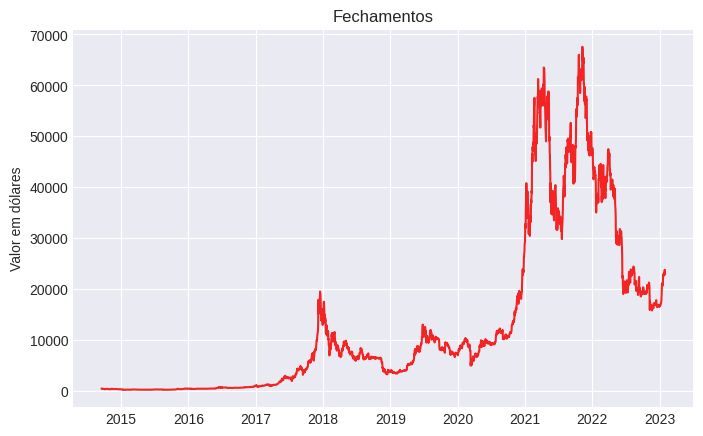

In [7]:
sns.lineplot(data=df, x='Data', y='Fechamento', color=COR_TESTE)

plt.title('Fechamentos')
plt.xlabel('')
plt.ylabel('Valor em dólares');

In [8]:
df_recente = df[df.index >= '2023-01-01']

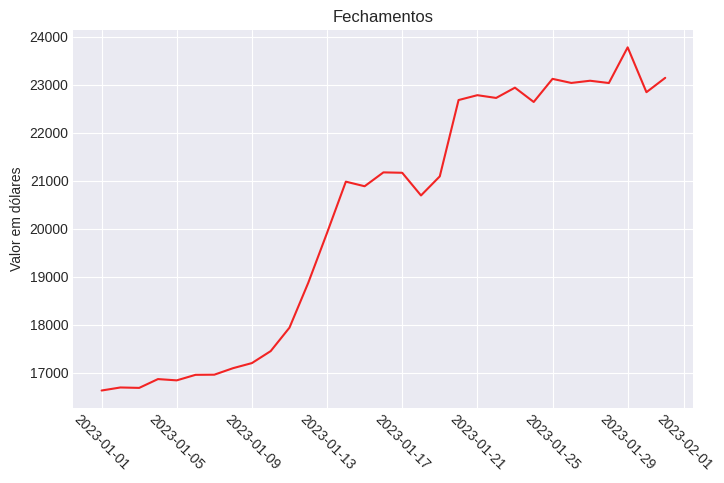

In [9]:
sns.lineplot(data=df_recente, x='Data', y='Fechamento', color=COR_TESTE)

plt.title('Fechamentos')
plt.xlabel('')
plt.ylabel('Valor em dólares')

plt.xticks(rotation=-45);

In [28]:
treino_tamanho = int(len(df) * 0.8)  # 80% da base
treino_tamanho

2447

In [29]:
X_train = df[:treino_tamanho].index
y_train = df[:treino_tamanho]['Fechamento'].to_numpy()

X_test = df[treino_tamanho:].index
y_test = df[treino_tamanho:]['Fechamento'].to_numpy()

len(X_train), len(y_train), len(X_test), len(y_test)

(2447, 2447, 612, 612)

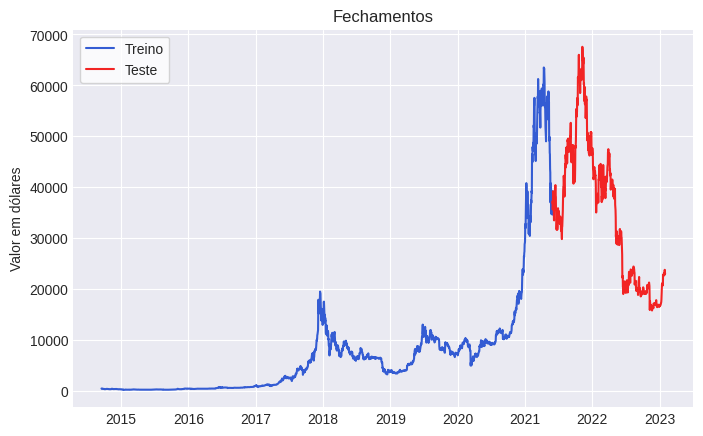

In [50]:
sns.lineplot(x=X_train, y=y_train, color=COR_TREINO, label='Treino')
sns.lineplot(x=X_test, y=y_test, color=COR_TESTE, label='Teste')

plt.title('Fechamentos')
plt.xlabel('')
plt.ylabel('Valor em dólares')

plt.legend(frameon=True, facecolor='white', loc='upper left');

# Modelos

0. Ingênuo
1. Denso (7 janelas, 1 horizonte.)
2. Denso (30 janelas, 1 horizonte.)
3. Denso (30 janelas, 7 horizontes.)
4. Conv1D
5. LSTM
6. Denso com dados multivariados
7. N-BEATS
8. Conjunto (Ensemble. Múltilplos modelos com funções de perda diferentes.)
9. Previsão futura
10. Denso com dados turcos (Turkey problem/data.)

---
Janelas: número de intervalos de tempo utilizados para fazer a previsão (passado).

Horizontes: número de intervalos de tempo da previsão (futuro).